In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.RiskSLIM as slim
import utils.stumps as stumps
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from pprint import pprint
from riskslim.helper_functions import load_data_from_csv, print_model

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\interpretable-machine-learning


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### EBM

In [8]:
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train.csv").sort_values('person_id')
train_data = train_data.drop(['person_id', 'screening_date', 'arnold_nca_raw', 'arnold_nvca_raw', 'arnold_fta_raw'], axis=1)
train_x = train_data.loc[:, :'current_violence20']
train_y = train_data['general_two_year']
cols = train_x.columns

In [4]:
ebm = ExplainableBoostingClassifier(feature_names=cols,
                                    n_estimators=60,  
                                    max_tree_splits=2, 
                                    learning_rate=0.1,
                                    random_state=816).fit(train_x, train_y)

In [5]:
ebm_global = ebm.explain_global()
show(ebm_global)

### Additive Stumps

In [16]:
## load train & test
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train_stumps.csv").sort_values('person_id')
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_test_stumps.csv").sort_values('person_id')

X_train_stumps = train_stumps.loc[:,:'current_violence201'].copy()
X_test_stumps = test_stumps.loc[:,:'current_violence201'].copy()
Y_train_stumps = train_stumps['general_two_year'].values.copy()
Y_test_stumps = test_stumps['general_two_year'].values.copy()
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0
cols = X_train_stumps.columns[3:]

In [17]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.002, 
                                      columns=cols, 
                                      seed=816)

In [19]:
## unique original features
unique_stumps = []
for i in best_stump_model['features']:
    unique_stumps.append(''.join([j for j in i if not j.isdigit()]))
print(len(np.unique(unique_stumps)))

14


In [20]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                         best_stump_model['features'], 
                         best_stump_model['intercept'], 
                         best_stump_model['dictionary'])

\begin{{tabular}}{{|l|r|r|}} \hline
1. age_at_current_charge20 & 0.008172335301239004 & +... \\ \hline
2. age_at_current_charge21 & 0.005261389499799182 & +... \\ \hline
3. age_at_current_charge24 & 0.03222744863636956 & +... \\ \hline
4. age_at_current_charge27 & 0.027026933544165025 & +... \\ \hline
5. age_at_current_charge35 & 0.010825266938525603 & +... \\ \hline
6. age_at_current_charge39 & 0.1223152119666769 & +... \\ \hline
7. age_at_current_charge43 & 0.031064901493189814 & +... \\ \hline
8. age_at_current_charge47 & 0.06861394349680994 & +... \\ \hline
9. p_arrest2 & 0.6762423397426611 & +... \\ \hline
10. p_arrest3 & 0.3488606942593477 & +... \\ \hline
11. p_arrest4 & 0.23394585556232336 & +... \\ \hline
12. p_arrest5 & 0.12261637081757945 & +... \\ \hline
13. p_charges2 & 0.012393311529462426 & +... \\ \hline
14. p_charges3 & 0.006542676971580426 & +... \\ \hline
15. p_violence1 & 0.047387025264398204 & +... \\ \hline
16. p_felony1 & 0.1721159271286281 & +... \\ \hline
17. p

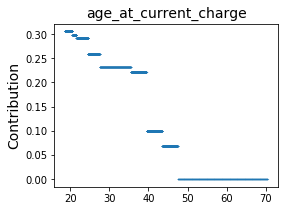

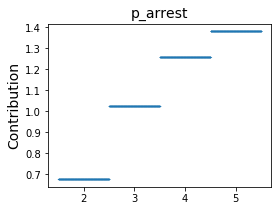

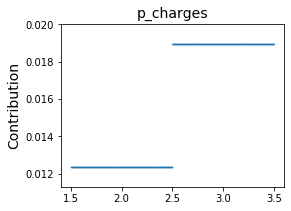

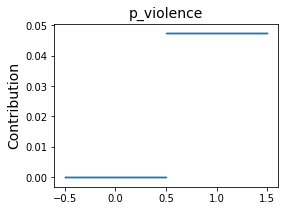

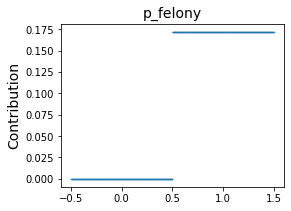

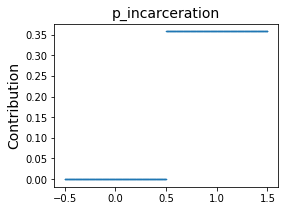

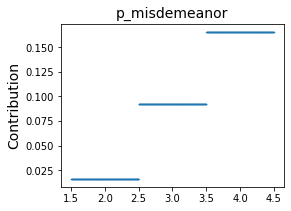

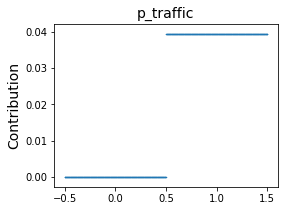

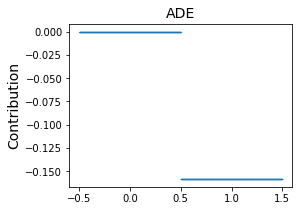

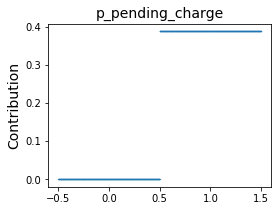

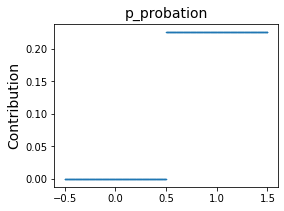

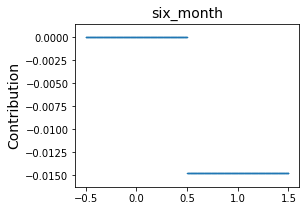

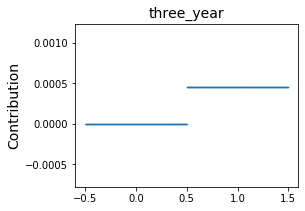

In [21]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator="KY")

### Visualization for 'p_fta_two_year'

In [34]:
label = 'p_fta_two_year'
features = best_stump_model['features']
coefs = best_stump_model['coefs']
cutoff_values = []
cutoffs = []

In [35]:
## sub-features
sub_features = np.array(np.array(features)[[label in k for k in features]])

for j in sub_features:
    cutoff_values.append( round(coefs[np.where(np.array(features) == j)[0][0]], 3))
    cutoffs.append(int(j[j.find(label)+len(label):])) 
    
## prepare cutoffs
cutoff_prep = []
cutoff_values_prep = []

for n in range(len(cutoffs)-1):
    cutoff_prep.append(np.linspace(cutoffs[n]-0.5, cutoffs[n+1]-0.5, 1000))
    cutoff_values_prep.append(np.repeat(round(np.sum(cutoff_values[:n+1]),3), 1000))
    
cutoff_prep.append(np.linspace(cutoffs[-1]-0.5, cutoffs[-1]+0.5, 1000))
cutoff_values_prep.append(np.repeat(np.sum(cutoff_values), 1000))

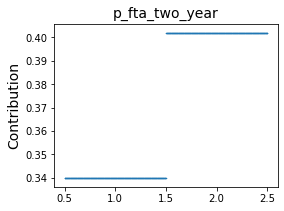

In [36]:
## visualization
unique = np.unique(cutoff_values_prep)
unique_len = len(unique)
plt.figure(figsize=(4,3))
plt.scatter(cutoff_prep, cutoff_values_prep, s=0.05)
plt.title(label, fontsize=14)
plt.ylabel('Contribution', fontsize=14)
plt.show()  

### RiskSLIM

In [38]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train_stumps.csv").sort_values('person_id')

## single stump model
single_stump_model = stumps.stump_model(X_train_stumps, 
                                        Y_train_stumps, 
                                        X_test_stumps, 
                                        Y_test_stumps, 
                                        c=0.0012,    
                                        columns=cols, 
                                        seed=816)

In [39]:
selected_features = ['general_two_year'] + single_stump_model['features']
sub_train_data = train_stumps[selected_features]
sub_test_data = test_stumps[selected_features]

## split x 
sub_train_X = sub_train_data.iloc[:,1:]
sub_train_X.insert(0, '(Intercept)', 1)
sub_cols = sub_train_X.columns.tolist()
sub_train_X = sub_train_X.values
sub_test_X = sub_test_data.iloc[:,1:].values

## split y
sub_train_Y = sub_train_data.iloc[:,0].values.reshape(-1,1)
sub_test_Y = sub_test_data.iloc[:,0].values.reshape(-1,1)

## sample weight
sample_weights = np.repeat(1, len(sub_train_Y))

In [40]:
new_train_data = {
    'X': sub_train_X,
    'Y': sub_train_Y,
    'variable_names': sub_cols,
    'outcome_name': 'general_two_year',
    'sample_weights': sample_weights
}

In [41]:
model_info, mip_info, lcpa_info = slim.risk_slim(new_train_data, 
                                                 max_coefficient=5, 
                                                 max_L0_value=5, 
                                                 c0_value=1e-6, 
                                                 max_offset=100, 
                                                 max_runtime=1000)
print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
04/05/20 @ 12:47 PM | 233 rows in lookup table
04/05/20 @ 12:47 PM | ------------------------------------------------------------
04/05/20 @ 12:47 PM | runnning initialization procedure
04/05/20 @ 12:47 PM | ------------------------------------------------------------
04/05/20 @ 12:47 PM | CPA produced 2 cuts
04/05/20 @ 12:47 PM | running naive rounding on 4 solutions
04/05/20 @ 12:47 PM | best objective value: 0.6930
04/05/20 @ 12:47 PM | rounding produced 4 integer solutions
04/05/20 @ 12:47 PM | best objective value is 0.6931
04/05/20 @ 12:47 PM | running sequential rounding on 4 solutions
04/05/20 @ 12:47 PM | best objective value: 0.6930
04/05/20 @ 12:47 PM | sequential rounding produced 1 integer solutions
04/05/20 @ 12:47 PM | best objective value: 0.5457
04/05/20 @ 12:47 PM | polishing 5 solutions
04/05/20 @ 12:47 PM | best objective value: 0.5457
04/05/20 @ 12:47 PM | polishing produced 4 integer solutions
04/05/20 @ 1

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
04/05/20 @ 12:47 PM | adding 260 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4683.
Tried aggregator 1 time.
Reduced MIP has 38 rows, 40 columns, and 111 nonzeros.
Reduced MIP has 18 binaries, 20 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  80371 23714        cutoff              0.4501        0.4363   736909    3.08%          rho_16 U  80371  57471     34
  81907 23795        cutoff              0.4501        0.4365   747578    3.03%          rho_14 D  81907  81905     33
  83474 23907        cutoff              0.4501        0.4367   758357    2.98%           rho_1 U  83474  21133     25
  85048 24046        0.4413    10        0.4501        0.4369   768739    2.95%        alpha_15 D  85048  85047     33
  86572 24174        0.4461    12        0.4501        0.4371   779465    2.91%           rho_6 N  86572   3847     20
  88063 24216        0.4464    17        0.4501        0.4372   789776    2.87%          rho_18 D  88063  33641     16
  89597 24273        0.4446    16        0.4501        0.4374   800131    2.83%           rho_4 D  89597  28247     28
  91111 24314        0.4487    12        0.4501        0.4376   810198    2.79%          rho_12 D  91111  91110     23
  92661 24377        cutoff              0.4501 